# VRPOR for Albert Heijn Pijnacker Distribution Center

This notebook implements and optimizes a Vehicle Routing Problem with Order Splitting and Penalties (VRPOR) for logistics operations from an Albert Heijn distribution center. The model's formulation aligns with standard VRP practices ("Table 2 alignment").

Key features:
*   Uses fixed geographic coordinates.
*   Scales time-related parameters proportionally for geographic distances.
*   Applies a consistent VRPOR mathematical model.


### Block 1: Setup and Helper Functions

This block imports all necessary Python libraries, including Gurobi. It also defines helper functions for Euclidean distance calculation, printing optimization summaries and detailed solution analyses, and plotting routes (both static Matplotlib and interactive Folium maps) and cost breakdowns. All functions are defined at the beginning to ensure availability throughout the notebook.

In [1]:
# Block 1: Setup, Imports, and Helper Functions
import gurobipy as gp
from gurobipy import GRB
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import folium 

print(f"Gurobi Optimizer version: {gp.gurobi.version()}")

# --- Helper Functions ---
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def print_results_summary(results):
    print("\n--- Optimization Summary ---")
    print(f"Status: {results.get('status_message', 'N/A')} (Code: {results.get('status_code', 'N/A')})")
    obj_val = results.get("objective_value")
    if obj_val is not None:
        print(f"Objective Value: {obj_val:.2f}")
        obj_comp = results.get("objective_components")
        if obj_comp: print(f"  Components: Travel={obj_comp['travel']:.2f}, Penalty={obj_comp['penalty']:.2f}, Split={obj_comp['split']:.2f} (Calc Sum: {obj_comp['calculated_total']:.2f})")
        else: print("  Objective components not calculated.")
        print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s")
        print(f"MIP Gap: {results.get('mip_gap','N/A'):.4f}" if results.get('mip_gap') is not None else "MIP Gap: N/A")
        print(f"Nodes Explored: {results.get('node_count','N/A')}\n")

        # More robust check for solution existence before accessing detailed parts
        sol = results.get("solution")
        if sol:
            print(f"Nodes Served: {results.get('nodes_served','N/A')} / {len(results['instance']['N_cust_customers'])}")
            routes = results.get("routes")
            if routes: print(f"\nRoutes Found ({len(routes)}):"); [print(f"  {k}: {' -> '.join(route)}") for k,route in routes.items()]
            else: print("\nNo valid routes extracted.")
            
            # Check for split deliveries and lateness
            split_visits_img = sol.get("split_extra_visits_image")
            lateness_pos_part_vals = sol.get("lateness_positive_part")
            volume_Y_jk_vals = sol.get("total_volume_Y_jk_for_penalty")

            if split_visits_img and any(v > 0.5 for v in split_visits_img.values()): 
                print("\nSplit Deliveries (Extra Visits > 0):")
                [print(f"  Node {j}: {int(round(extra))} extra visit(s)") for j, extra in split_visits_img.items() if extra > 0.5]
            
            if lateness_pos_part_vals and volume_Y_jk_vals:
                late_entries = []
                for (j_sat, k_veh), lateness_val in lateness_pos_part_vals.items():
                    vol_val = volume_Y_jk_vals.get((j_sat, k_veh), 0)
                    if lateness_val > 1e-4 and vol_val > 1e-4: # Only if both lateness and volume are significant
                        late_entries.append(f"  Node {j_sat} by Veh {k_veh}: {lateness_val:.2f} time units late (Volume: {vol_val:.2f})\n")
                if late_entries:
                    print("\nLate Deliveries at Satellites (Lateness > 0):")
                    for entry in late_entries: print(entry)
        else:
            print("No detailed solution information available (solution not found).\n")
    else:
        print("No feasible solution found or optimization failed.")
        print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s")
        print(f"Nodes Explored: {results.get('node_count','N/A')}")
    print("--------------------------\n")

def print_detailed_solution_analysis(results):
    instance = results.get("instance")
    solution = results.get("solution")
    routes = results.get("routes")

    if not solution or not routes:
        print("\n--- Detailed Solution Analysis ---")
        print("No solution found or no routes extracted for detailed analysis.")
        print("----------------------------------\n")
        return

    print("\n--- Detailed Solution Analysis ---")
    
    depot = instance["depot_node"]
    S_stores = instance["S_stores"]
    M_phys_satellites = instance["M_phys_satellites"]
    N_cust_customers = instance["N_cust_customers"]
    
    # Extract necessary parameters from the instance
    # coords = instance["coords"] # Not used here, but good for context
    d_ij = instance["d_ij"]
    t_ij = instance["t_ij"]
    o_i = instance["o_i"]
    l_i = instance["l_i"]
    V_star = instance["V_star"]
    V_r = instance["V_r"]
    V_b = instance["V_b"]
    D_i_r = instance["D_i_r"]
    D_i_b = instance["D_i_b"]

    # Extract necessary solution variables
    sol_x = solution["x"]
    sol_Q = solution["Q"]
    sol_Y = solution["Y"]
    sol_t_arrival = solution["t_arrival"]
    sol_lateness_positive_part = solution["lateness_positive_part"]
    sol_split_extra_visits = solution["split_extra_visits_image"]

    # 1. Vehicle Route Details
    print("\n=== Vehicle Route Details ===")
    # vehicle_utilization = {} # If needed, uncomment and populate this dict
    for k_veh, route_nodes in routes.items():
        total_route_distance = 0
        total_route_time_on_road = 0 # Only travel time
        
        print(f"\n--- Vehicle {k_veh} ---")
        print(f"  Route: {' -> '.join(route_nodes)}")
        
        # Calculate route specific metrics
        for i in range(len(route_nodes) - 1):
            from_node = route_nodes[i]
            to_node = route_nodes[i+1]
            dist_seg = d_ij.get((from_node, to_node), 0)
            time_seg = t_ij.get((from_node, to_node), 0)
            
            total_route_distance += dist_seg
            total_route_time_on_road += time_seg
            
            # Deliveries at 'to_node' (assuming delivery happens *at* the destination node of an arc)
            if to_node in S_stores:
                # Sum deliveries for this vehicle and this store
                delivered_volume_store = sum(V_r[r_prod] * sol_Q.get((to_node, k_veh, r_prod), 0) for r_prod in instance["R_product_types"])
                if delivered_volume_store > 0.001:
                    print(f"    Delivered {delivered_volume_store:.2f} volume to {to_node} (Store).")
            elif to_node in M_phys_satellites:
                # Sum deliveries for this vehicle and this satellite
                delivered_volume_sat = sum(V_b[b_ord] * sol_Y.get((to_node, k_veh, b_ord), 0) for b_ord in instance["B_order_types"])
                if delivered_volume_sat > 0.001:
                    print(f"    Delivered {delivered_volume_sat:.2f} volume to {to_node} (Satellite).")
                    
                    # Check for lateness at this satellite delivery by this vehicle
                    if (to_node, k_veh) in sol_lateness_positive_part and sol_lateness_positive_part[(to_node, k_veh)] > 1e-4:
                        print(f"    !!! LATE ARRIVAL at {to_node}: Arrived {sol_t_arrival.get((to_node,k_veh),0):.2f}, Deadline {l_i.get(to_node,0):.2f}, Lateness {sol_lateness_positive_part[(to_node, k_veh)]:.2f}")

        # Calculate total volume carried by the vehicle for the entire route (throughput)
        total_volume_throughput = sum(V_r[r_prod] * sol_Q.get((j_store, k_veh, r_prod), 0) 
                                      for j_store in S_stores for r_prod in instance["R_product_types"]) + \
                                  sum(V_b[b_ord] * sol_Y.get((j_sat, k_veh, b_ord), 0) 
                                      for j_sat in M_phys_satellites for b_ord in instance["B_order_types"])
        
        total_route_duration_from_solution = sol_t_arrival.get((depot, k_veh), 0) if route_nodes and route_nodes[-1] == depot else "N/A (Route not closed or solution issue)"
        
        print(f"  Total Route Distance: {total_route_distance:.2f} units")
        print(f"  Total Route Duration (from solution): {total_route_duration_from_solution:.2f} units")
        print(f"  Total Volume Throughput by Vehicle: {total_volume_throughput:.2f} volume units")
        
        if V_star > 0:
            # Note: This is an average throughput utilization, not peak load. Peak load requires flow variables.
            # vehicle_utilization[k_veh] = total_volume_throughput / V_star
            print(f"  Vehicle Throughput Utilization: {(total_volume_throughput / V_star):.2%}")
        else:
            print("  Vehicle capacity V_star is zero, cannot calculate utilization.")
        
        # print("\n  Path Segments:") # Uncomment if you want to print each segment in detail
        # for segment in path_segments:
        #     print(segment)
        # print("")

    # 2. Customer Delivery Details (aggregated across vehicles)
    print("\n=== Customer Delivery Details ===")
    for j_node in N_cust_customers:
        print(f"\n--- Customer {j_node} ---")
        
        # Check for split deliveries
        if j_node in sol_split_extra_visits and sol_split_extra_visits[j_node] > 0.5:
            arrival_count = round(sol_split_extra_visits[j_node]) + 1 
            print(f"  !!! Split Delivery: Visited {arrival_count} times.")
        else:
            # Confirm if visited at all (not just if split variable is zero)
            is_visited = False
            for (i,j,k), val in sol_x.items():
                if j == j_node and k in instance["VF_fleet"] and val > 0.5: # Ensure k is a valid vehicle to prevent key errors
                    is_visited = True
                    break
            if is_visited:
                print("  Visited 1 time (no split delivery).\n")
            else:
                print("  !!! Not visited by any vehicle (demand may be unfulfilled or error - check model constraints).\n")

        if j_node in S_stores:
            total_required_volume = sum(D_i_r.get((j_node, r_prod), 0) * V_r[r_prod] for r_prod in instance["R_product_types"])
            total_delivered_volume = 0
            for k_veh in instance["VF_fleet"]:
                total_delivered_volume += sum(V_r[r_prod] * sol_Q.get((j_node, k_veh, r_prod), 0) for r_prod in instance["R_product_types"])
            
            print(f"  Type: Store")
            print(f"  Required Volume: {total_required_volume:.2f} units")
            print(f"  Delivered Volume: {total_delivered_volume:.2f} units (Matched: {abs(total_delivered_volume - total_required_volume) < 1e-4})")
            print(f"  Hard Deadline: {l_i.get(j_node, 'N/A'):.2f}")
            print(f"  Service Time: {o_i.get(j_node, 'N/A'):.2f}")
            # Also show arrival times for each vehicle that visited
            for k_veh in instance["VF_fleet"]:
                # Check if this vehicle visited j_node
                visited_by_k = False
                for (i,j,k), val in sol_x.items():
                    if j == j_node and k == k_veh and val > 0.5:
                        visited_by_k = True
                        break
                if visited_by_k:
                    print(f"    Arrival Time (Veh {k_veh}): {sol_t_arrival.get((j_node, k_veh),0):.2f}")

        elif j_node in M_phys_satellites:
            total_required_volume = sum(D_i_b.get((j_node, b_ord), 0) * V_b[b_ord] for b_ord in instance["B_order_types"])
            total_delivered_volume = 0
            for k_veh in instance["VF_fleet"]:
                total_delivered_volume += sum(V_b[b_ord] * sol_Y.get((j_node, k_veh, b_ord), 0) for b_ord in instance["B_order_types"])
            
            print(f"  Type: Satellite")
            print(f"  Required Volume: {total_required_volume:.2f} units")
            print(f"  Delivered Volume: {total_delivered_volume:.2f} units (Matched: {abs(total_delivered_volume - total_required_volume) < 1e-4})")
            print(f"  Soft Deadline: {l_i.get(j_node, 'N/A'):.2f}")
            print(f"  Service Time: {o_i.get(j_node, 'N/A'):.2f}")

            # Check for any lateness across all visits for this satellite
            lateness_info = []
            for k_veh in instance["VF_fleet"]:
                if (j_node, k_veh) in sol_lateness_positive_part and sol_lateness_positive_part[(j_node, k_veh)] > 1e-4:
                    lateness_info.append(f"  Vehicle {k_veh} - Arrived {sol_t_arrival.get((j_node, k_veh), 0):.2f}, Late by {sol_lateness_positive_part[(j_node, k_veh)]:.2f}")
            if lateness_info:
                print("  Lateness Details:")
                for info in lateness_info: print(info)
            # Also show arrival times for each vehicle that visited
            for k_veh in instance["VF_fleet"]:
                visited_by_k = False
                for (i,j,k), val in sol_x.items():
                    if j == j_node and k == k_veh and val > 0.5:
                        visited_by_k = True
                        break
                if visited_by_k:
                    print(f"    Arrival Time (Veh {k_veh}): {sol_t_arrival.get((j_node, k_veh),0):.2f}")
        
    print("----------------------------------\n")


def plot_solution_routes(results): # Matplotlib plot
    instance = results.get("instance"); routes = results.get("routes")
    if not instance or not routes or not instance.get("coords"): 
        print("Cannot plot (matplotlib): Missing instance, routes, or coordinates."); return
        
    coords = instance["coords"]; depot = instance["depot_node"]
    S_nodes = instance["S_stores"]; M_nodes = instance["M_phys_satellites"]
    is_fixed_coords = instance.get("using_fixed_coords", False)

    plt.figure(figsize=(12,10))
    x_idx, y_idx = (1, 0) if is_fixed_coords else (0, 1) 
    xlabel, ylabel = ("Longitude", "Latitude") if is_fixed_coords else ("X-coord", "Y-coord")
    text_offset = 0.001 if is_fixed_coords else 0.8

    if depot in coords:
        plt.scatter(coords[depot][x_idx], coords[depot][y_idx], c='black', marker='s', s=150, label=f'Depot ({depot})', zorder=5)
    
    if S_nodes: 
        s_coords_to_plot = [(coords[s][x_idx], coords[s][y_idx]) for s in S_nodes if s in coords]
        if s_coords_to_plot:
            plt.scatter(*zip(*s_coords_to_plot), c='blue', marker='o', s=80, label='Stores (S)', zorder=5)
            
    if M_nodes: 
        m_coords_to_plot = [(coords[m][x_idx], coords[m][y_idx]) for m in M_nodes if m in coords]
        if m_coords_to_plot:
            plt.scatter(*zip(*m_coords_to_plot), c='red', marker='^', s=80, label='Satellites (M_phys)', zorder=5)

    for node_id, node_coords_tuple in coords.items():
        plt.text(node_coords_tuple[x_idx], node_coords_tuple[y_idx] + text_offset, node_id, fontsize=9, ha='center')
    
    num_r = len(routes); colors = plt.cm.viridis(np.linspace(0,1,max(1,num_r))) if num_r >0 else ['gray']
    veh_idx = 0
    for k,route in routes.items():
        route_coords_list = []
        for node_in_route in route:
            if node_in_route in coords: 
                route_coords_list.append((coords[node_in_route][x_idx], coords[node_in_route][y_idx]))
            else: print(f"Warning: Node {node_in_route} in route for vehicle {k} not in coords dict."); return 
        if not route_coords_list: continue
        
        route_coords_arr = np.array(route_coords_list)
        plt.plot(route_coords_arr[:,0], route_coords_arr[:,1], linestyle='-', marker='.', color=colors[min(veh_idx, len(colors)-1)], label=f'Veh {k}', lw=1.5, ms=5)
        veh_idx+=1
        
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title("Vehicle Routes (Matplotlib)")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=min(5,num_r+3 if num_r else 1))
    plt.grid(True,ls='--',alpha=0.6)
    if not is_fixed_coords: 
        plt.axis('equal') 
    plt.tight_layout(rect=[0,0.05,1,1]); plt.show()

def plot_cost_breakdown(results):
    obj_comp = results.get("objective_components"); obj_val = results.get("objective_value")
    if not obj_comp or obj_val is None or abs(obj_val) <=1e-6 : 
        print("Cannot plot cost: Missing components or zero/neg objective."); return
    
    precision = ".4f" if results.get('instance', {}).get('using_fixed_coords', False) else ".2f"
    labels = ['Travel','Penalty (Lateness)','Split Cost']
    sizes = [obj_comp.get('travel',0), obj_comp.get('penalty',0), obj_comp.get('split',0)]
    
    labels_f = [l for i,l in enumerate(labels) if abs(sizes[i])>1e-6]; 
    sizes_f = [s for s in sizes if abs(s)>1e-6]
    if not sizes_f: print("Cost breakdown: All components are zero/negligible."); return
    
    fig,ax = plt.subplots(figsize=(7,7))
    wedges, texts, autotexts = ax.pie(sizes_f, labels=labels_f, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    ax.axis('equal'); plt.title(f'Objective Cost Breakdown (Total: {obj_val:{precision}})')
    centre_circle=plt.Circle((0,0),0.70,fc='white'); fig.gca().add_artist(centre_circle)
    plt.setp(autotexts, size=10, weight="bold", color="white")
    plt.setp(texts, size=12)
    plt.tight_layout(); plt.show()

# --- NEW FUNCTION FOR FOLIUM MAP ---
def plot_solution_routes_on_map(results, map_filename="vrp_routes_map.html"):
    instance = results.get("instance")
    routes_dict = results.get("routes")

    if not instance or not routes_dict or not instance.get("coords"):
        print("Cannot plot Folium map: Missing instance data, routes, or coordinates.")
        return
    
    if not instance.get("using_fixed_coords", False):
        print("Folium map is most meaningful for geographic (fixed) coordinates. Skipping for random coordinates.")
        return

    coords = instance["coords"] 
    depot_node = instance["depot_node"]
    S_nodes = instance["S_stores"]
    M_nodes = instance["M_phys_satellites"]
    deadlines = instance.get("l_i", {})

    if depot_node not in coords:
        print(f"Depot node '{depot_node}' coordinates not found. Cannot create map.")
        return

    # Folium expects (latitude, longitude)
    map_center = coords[depot_node] 
    m = folium.Map(location=map_center, zoom_start=12, tiles="OpenStreetMap")

    # Depot Marker
    folium.Marker(
        location=coords[depot_node],
        popup=f"Depot: {depot_node}",
        tooltip=f"Depot: {depot_node}",
        icon=folium.Icon(color="black", icon="industry", prefix="fa")
    ).add_to(m)

    # Store Markers
    for s_node in S_nodes:
        if s_node in coords:
            popup_text = f"Store: {s_node}<br>Deadline: {deadlines.get(s_node, 'N/A'):.2f}"
            folium.Marker(
                location=coords[s_node],
                popup=popup_text,
                tooltip=f"Store: {s_node}",
                icon=folium.Icon(color="blue", icon="shopping-cart", prefix="fa")
            ).add_to(m)

    # Satellite Markers
    for m_node in M_nodes:
        if m_node in coords:
            popup_text = f"Satellite: {m_node}<br>Deadline: {deadlines.get(m_node, 'N/A'):.2f}"
            folium.Marker(
                location=coords[m_node],
                popup=popup_text,
                tooltip=f"Satellite: {m_node}",
                icon=folium.Icon(color="red", icon="home", prefix="fa") # Changed icon for satellites
            ).add_to(m)
    
    num_routes = len(routes_dict)
    if num_routes > 0:
        # Generate distinct colors for routes
        route_colors_mpl = plt.cm.get_cmap('gist_rainbow', num_routes) # Using a vibrant colormap
        colors_hex = [plt.matplotlib.colors.to_hex(route_colors_mpl(i)) for i in range(num_routes)]
    else:
        colors_hex = ['gray'] # Fallback color if no routes
    
    route_idx = 0
    for vehicle, route_nodes in routes_dict.items():
        route_lat_lon = []
        for node_id in route_nodes:
            if node_id in coords:
                route_lat_lon.append(coords[node_id]) # Folium expects (lat,lon)
            else:
                print(f"Warning: Node {node_id} in route for vehicle {vehicle} not in coords dict.")
                continue # Skip this node if not found
        
        if len(route_lat_lon) > 1: # Need at least two points to draw a line
            color_to_use = colors_hex[route_idx % len(colors_hex)] 
            folium.PolyLine(
                locations=route_lat_lon,
                color=color_to_use,
                weight=2.5,
                opacity=0.8,
                tooltip=f"Route: Vehicle {vehicle}"
            ).add_to(m)
            # Optional: Add small circle markers for each stop on the route
            # for point_idx, point_coords in enumerate(route_lat_lon):
            #      folium.CircleMarker(location=point_coords, radius=3, color=color_to_use, fill=True, 
            #                          fill_color=color_to_use, fill_opacity=0.7, 
            #                          tooltip=f"Veh {vehicle}: {route_nodes[point_idx]} (Stop {point_idx+1})").add_to(m)
            route_idx += 1

    try:
        m.save(map_filename)
        print(f"Folium map saved as {map_filename}. Open this file in a web browser to view.")
    except Exception as e:
        print(f"Error saving Folium map: {e}")

Gurobi Optimizer version: (11, 0, 0)


### Block 2: Instance Generation Function

This block defines `generate_instance_table2_final`, which creates the data for a VRPOR instance.
*   It supports both random and fixed (geographic) coordinates.
*   Parameters like service times and deadline margins are scaled down when fixed coordinates are used to maintain realistic proportions to travel distances.
*   Node definitions, distances, and times are generated.
*   Product/order volumes and demands are set within specified ranges.
*   Vehicle fleet size is calculated based on total demand and capacity.

In [2]:
# Block 2: Instance Generation Function
# This function generates the data for a VRPOR instance.
# It's modified to accept 'fixed_coords' for specific scenarios like the AH Pijnacker case.
# If fixed_coords are used (assumed lat/lon), service times and deadline margins are scaled.

def generate_instance_table2_final(num_stores, num_physical_satellites, num_products, num_orders,
                                   vehicle_capacity_V_star, penalty_pu_param, split_ps_param,
                                   seed=42, vehicle_buffer=0, fixed_coords=None):
    random.seed(seed)

    # --- SET DEFINITIONS (as per LaTeX derived from Table 2) ---
    depot_node_0 = 'D0' 

    set_S_stores = [f"S{s_idx+1}" for s_idx in range(num_stores)]
    _physical_sat_nodes_temp = [f"M{m_idx+1}" for m_idx in range(num_physical_satellites)]
    set_M_T2_sats_and_depot = [depot_node_0] + _physical_sat_nodes_temp 
    set_M_phys_physical_satellites = _physical_sat_nodes_temp
    set_N_cust_all_customers = set_S_stores + set_M_phys_physical_satellites
    set_N_all_network_nodes = list(set(set_S_stores + set_M_T2_sats_and_depot))
    set_L_arcs = [(i, j) for i in set_N_all_network_nodes for j in set_N_all_network_nodes if i != j]
    set_R_product_types = [f"P{r_idx+1}" for r_idx in range(num_products)]
    set_B_order_types = [f"B{b_idx+1}" for b_idx in range(num_orders)]

    # --- PARAMETERS ---
    param_coords = {}
    using_fixed_coords_flag = bool(fixed_coords)
    if fixed_coords:
        print("INFO: Using fixed_coords for node locations.")
        if depot_node_0 not in fixed_coords: raise ValueError(f"Depot {depot_node_0} not in fixed_coords.")
        param_coords[depot_node_0] = fixed_coords[depot_node_0]
        
        for s_node_name in set_S_stores:
            if s_node_name not in fixed_coords: raise ValueError(f"Store {s_node_name} not in fixed_coords.")
            param_coords[s_node_name] = fixed_coords[s_node_name]
        
        for m_node_name in set_M_phys_physical_satellites:
            if m_node_name not in fixed_coords: raise ValueError(f"Satellite {m_node_name} not in fixed_coords.")
            param_coords[m_node_name] = fixed_coords[m_node_name]
    else:
        print("INFO: Using random coordinates for node locations.")
        param_coords[depot_node_0] = (0, 0)
        for i_node in set_S_stores: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25))
        for i_node in set_M_phys_physical_satellites: param_coords[i_node] = (random.uniform(-25, 25), random.uniform(-25, 25))

    param_d_ij_dist = {}; param_t_ij_time = {}; max_travel_t_val = 0
    for i_node, j_node in set_L_arcs:
        dist_val = euclidean_distance(param_coords[i_node], param_coords[j_node])
        param_d_ij_dist[i_node, j_node] = dist_val
        param_t_ij_time[i_node, j_node] = dist_val 
        max_travel_t_val = max(max_travel_t_val, param_t_ij_time[i_node, j_node])
    for i_node in set_N_all_network_nodes : param_d_ij_dist[i_node,i_node]=0; param_t_ij_time[i_node,i_node]=0

    param_o_i_service = {node: 0 for node in set_N_all_network_nodes} 
    total_serv_t_val = 0
    for node_cust in set_N_cust_all_customers:
        if using_fixed_coords_flag: 
            # Scaled for lat/lon for realistic proportion to travel time
            param_o_i_service[node_cust] = random.uniform(0.005, 0.025) 
        else:
            param_o_i_service[node_cust] = random.uniform(3, 10) # Original scale
        total_serv_t_val += param_o_i_service[node_cust]

    # V_r, V_b: [1, 10] per paper
    param_V_r_volume = {r_prod: random.randint(1, 10) for r_prod in set_R_product_types}
    param_V_b_volume = {b_ord: random.randint(1, 10) for b_ord in set_B_order_types}

    # D_i_r, D_i_b: [10, 20] per paper
    param_D_i_r_S_demand = {}; total_vol_demand_S = 0
    for j_store in set_S_stores:
        for r_prod in set_R_product_types:
            demand_val = random.randint(10, 20)
            param_D_i_r_S_demand[j_store, r_prod] = demand_val
            total_vol_demand_S += param_V_r_volume[r_prod] * demand_val

    param_D_i_b_Mphys_demand = {}; total_vol_demand_M_phys = 0
    for j_sat_phys in set_M_phys_physical_satellites:
        for b_ord in set_B_order_types:
            demand_val = random.randint(10, 20)
            param_D_i_b_Mphys_demand[j_sat_phys, b_ord] = demand_val
            total_vol_demand_M_phys += param_V_b_volume[b_ord] * demand_val
    total_overall_demand_vol = total_vol_demand_S + total_vol_demand_M_phys

    param_l_i_deadline = {}
    max_deadln_val = 0
    for node_cust in set_N_cust_all_customers:
        min_req_t = param_t_ij_time.get((depot_node_0, node_cust), float('inf')) + param_o_i_service.get(node_cust, 0)
        if using_fixed_coords_flag:
            # Scaled for lat/lon for realistic proportion to travel time
            deadline_margin = random.uniform(0.05, 0.25) 
        else:
            deadline_margin = random.uniform(15, 50) # Original scale
        base_deadln_val = min_req_t + deadline_margin
        param_l_i_deadline[node_cust] = max(min_req_t + 0.001, base_deadln_val)
        max_deadln_val = max(max_deadln_val, param_l_i_deadline[node_cust])
    
    # Robust depot deadline and Big-M
    max_possible_route_time_estimate = (len(set_N_all_network_nodes)) * max_travel_t_val + total_serv_t_val
    param_l_i_deadline[depot_node_0] = max(max_deadln_val, 0.1) + max_possible_route_time_estimate 
    param_M_TIME_for_big_M = param_l_i_deadline[depot_node_0] * 1.5 
    if using_fixed_coords_flag and param_M_TIME_for_big_M < 50: # Ensure M is not too small for lat/lon
        param_M_TIME_for_big_M = max(50, sum(t for t in param_t_ij_time.values() if t < float('inf')) + sum(param_o_i_service.values()) + 10)


    numerator_eq1 = total_overall_demand_vol
    min_vehicles_eq1_val = math.ceil(numerator_eq1 / vehicle_capacity_V_star) if vehicle_capacity_V_star > 0 else len(set_N_cust_all_customers)
    if vehicle_capacity_V_star <= 0: print(f"Warning: vehicle_capacity_V_star is {vehicle_capacity_V_star}. Using fallback for min_vehicles_eq1_val.")
    
    num_vehicles_in_fleet = int(min_vehicles_eq1_val + vehicle_buffer)
    if num_vehicles_in_fleet == 0 and len(set_N_cust_all_customers) > 0:
        num_vehicles_in_fleet = 1
        print(f"Warning: Calculated num_vehicles_in_fleet was 0, set to 1 as there are customers.")
    set_VF_fleet = [f"K{k_idx+1}" for k_idx in range(num_vehicles_in_fleet)]

    instance_data = {
        "S_stores": set_S_stores, "M_T2_sats_and_depot": set_M_T2_sats_and_depot,
        "M_phys_satellites": set_M_phys_physical_satellites, "N_cust_customers": set_N_cust_all_customers,
        "N_all_network_nodes": set_N_all_network_nodes, "L_arcs": set_L_arcs,
        "depot_node": depot_node_0, "R_product_types": set_R_product_types,
        "B_order_types": set_B_order_types, "VF_fleet": set_VF_fleet,
        "coords": param_coords, "d_ij": param_d_ij_dist, "t_ij": param_t_ij_time,
        "o_i": param_o_i_service, "V_r": param_V_r_volume,
        "V_b": param_V_b_volume, "D_i_r": param_D_i_r_S_demand,
        "D_i_b": param_D_i_b_Mphys_demand, "l_i": param_l_i_deadline,
        "V_star": vehicle_capacity_V_star, "p_u": penalty_pu_param,
        "p_s": split_ps_param, "M_TIME_BIG": param_M_TIME_for_big_M,
        "total_demand_vol_overall": total_overall_demand_vol, "min_vehicles_eq1": min_vehicles_eq1_val,
        "vehicle_buffer": vehicle_buffer,
        "using_fixed_coords": using_fixed_coords_flag
    }
    return instance_data

### Block 3: VRPOR Model Building and Solving Function

This block contains `solve_vrpor_table2_final`, which uses Gurobi to construct and solve the VRPOR mathematical model.
*   The model strictly adheres to the variable names, objective, and constraint formulations from the original "Table 2 alignment" paper.
*   Decision variables include `x` (binary for arc traversal), `Q` (integer for store product quantity), `Y` (integer for satellite order quantity), and `t_arrival` (continuous for arrival times).
*   The objective minimizes travel cost, lateness penalties for satellites, and split delivery costs.
*   Constraints cover flow conservation, vehicle capacity, demand satisfaction, time propagation, and hard time windows for stores.
*   Symmetry-breaking constraints are added to improve solver performance.
*   The function extracts and processes the solution for reporting and visualization.

In [3]:
# Block 3: VRPOR Model Building Function (Reverted to Original Style)
# This function defines and solves the VRPOR model using Gurobi,
# strictly adhering to the variable names, objective, and constraint formulations
# from the original "Table 2 alignment" code.

def solve_vrpor_table2_final(instance, time_limit=60, mip_gap=0.001, log_to_console=0):
    S = instance["S_stores"]; M_T2 = instance["M_T2_sats_and_depot"]; M_phys = instance["M_phys_satellites"]
    N_cust = instance["N_cust_customers"]; N_all = instance["N_all_network_nodes"]
    L_arcs_set = instance["L_arcs"]; depot = instance["depot_node"]
    R_set = instance["R_product_types"]; B_set = instance["B_order_types"]; VF_set = instance["VF_fleet"]
    d_ij = instance["d_ij"]; t_ij = instance["t_ij"]; o_i = instance["o_i"]
    V_r = instance["V_r"]; V_b = instance["V_b"]; D_i_r = instance["D_i_r"] 
    D_i_b = instance["D_i_b"]; l_i = instance["l_i"]; V_star = instance["V_star"] 
    p_u = instance["p_u"]; p_s = instance["p_s"]; M_BIG = instance["M_TIME_BIG"]

    model = gp.Model("VRPOR_Table2_StrictFinal_FixedCoords") # Model name updated
    model.Params.LogToConsole = log_to_console
    model.Params.TimeLimit = time_limit; model.Params.MIPGap = mip_gap; model.Params.NonConvex = 2

    # --- Decision Variables (as per LaTeX Table 2) ---
    x = model.addVars(L_arcs_set, VF_set, vtype=GRB.BINARY, name="x") 
    Q = model.addVars(S, VF_set, R_set, vtype=GRB.INTEGER, lb=0.0, name="Q") 
    Y = model.addVars(M_phys, VF_set, B_set, vtype=GRB.INTEGER, lb=0.0, name="Y") 
    t_arrival = model.addVars(N_all, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_k_j")

    # --- Auxiliary Variables for Objective ---
    t_minus_l_positive = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="t_minus_l_pos")
    volume_Y_jk = model.addVars(M_phys, VF_set, vtype=GRB.CONTINUOUS, lb=0.0, name="vol_Y_jk")
    total_arrivals_at_j = model.addVars(N_cust, vtype=GRB.INTEGER, lb=0.0, name="total_arrivals_j")
    extra_arrivals_at_j_positive = model.addVars(N_cust, vtype=GRB.CONTINUOUS, lb=0.0, name="extra_arrivals_j_pos")
    zero_var = model.addVar(lb=0.0, ub=0.0, name="zero_constant_for_max")

    # --- Objective Function (Eq. 2 from LaTeX) ---
    term1_travel_cost = gp.quicksum(d_ij[i_node,j_node] * x[i_node,j_node,k_veh]
                                   for (i_node,j_node) in L_arcs_set for k_veh in VF_set)

    for j_sat in M_phys: # These must be defined even if M_phys or B_set is empty for term2_penalty_cost to sum correctly
        for k_veh in VF_set:
            model.addConstr(t_minus_l_positive[j_sat, k_veh] >= t_arrival[j_sat, k_veh] - l_i[j_sat], name=f"def_t_minus_l_pos_{j_sat}_{k_veh}")
            model.addConstr(volume_Y_jk[j_sat, k_veh] == gp.quicksum(V_b[b_ord] * Y[j_sat, k_veh, b_ord]
                                                                    for b_ord in B_set if (j_sat,k_veh,b_ord) in Y), name=f"def_vol_Y_{j_sat}_{k_veh}")
    term2_penalty_cost = gp.quicksum(p_u * t_minus_l_positive[j_sat, k_veh] * volume_Y_jk[j_sat, k_veh]
                                      for j_sat in M_phys for k_veh in VF_set)

    for j_node_cust in N_cust: # These must be defined for term3_split_cost
        model.addConstr(total_arrivals_at_j[j_node_cust] == gp.quicksum(x[i_node, j_node_cust, k_veh]
                                                                    for (i_node, _j) in L_arcs_set if _j == j_node_cust 
                                                                    for k_veh in VF_set), name=f"def_total_arrivals_{j_node_cust}")
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= total_arrivals_at_j[j_node_cust] - 1, name=f"def_extra_arr_ge_m1_{j_node_cust}")
        model.addConstr(extra_arrivals_at_j_positive[j_node_cust] >= zero_var, name=f"def_extra_arr_ge_0_{j_node_cust}")
    term3_split_cost = p_s * gp.quicksum(extra_arrivals_at_j_positive[j_node_cust] for j_node_cust in N_cust)

    model.setObjective(term1_travel_cost + term2_penalty_cost + term3_split_cost, GRB.MINIMIZE)

    # --- Constraints (Eqs. 3-16 from LaTeX) ---
    # Eq. 3
    model.addConstr(gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set for k_veh in VF_set) <= len(VF_set), "PaperEq3_TotalDepartures")

    # Eq. 4
    for k_veh in VF_set:
        sum_out_depot = gp.quicksum(x[depot,j_node_cust,k_veh] for j_node_cust in N_cust if (depot,j_node_cust) in L_arcs_set)
        sum_in_depot  = gp.quicksum(x[i_node_cust,depot,k_veh] for i_node_cust in N_cust if (i_node_cust,depot) in L_arcs_set)
        model.addConstr(sum_out_depot == sum_in_depot, f"PaperEq4_ReturnToDepot_{k_veh}")
        model.addConstr(sum_out_depot <= 1, f"PaperEq4_DepartDepotOnce_{k_veh}")

    # Eq. 5
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            model.addConstr(gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust) <= 1, f"PaperEq5_VisitCustOncePerVeh_{k_veh}_{j_node_cust}")

    # Eq. 6
    for k_veh in VF_set:
        for j_node_cust in N_cust:
            inflow_j = gp.quicksum(x[i_node,j_node_cust,k_veh] for i_node in N_all if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust)
            outflow_j = gp.quicksum(x[j_node_cust,l_node,k_veh] for l_node in N_all if (j_node_cust,l_node) in L_arcs_set and l_node != j_node_cust)
            model.addConstr(inflow_j - outflow_j == 0, f"PaperEq6_FlowConservation_{k_veh}_{j_node_cust}")

    # Eq. 7
    for j_store in S:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_store, k_veh] for i_node in N_all if (i_node, j_store) in L_arcs_set and i_node != j_store)
            for r_prod in R_set:
                if (j_store, r_prod) in D_i_r:
                     model.addConstr(Q[j_store, k_veh, r_prod] <= D_i_r[j_store, r_prod] * vehicle_visits_j, f"PaperEq7_LinkQtoX_{j_store}_{k_veh}_{r_prod}")

    # Eq. 8
    for j_sat in M_phys:
        for k_veh in VF_set:
            vehicle_visits_j = gp.quicksum(x[i_node, j_sat, k_veh] for i_node in N_all if (i_node, j_sat) in L_arcs_set and i_node != j_sat)
            for b_ord in B_set:
                 if (j_sat, b_ord) in D_i_b:
                    model.addConstr(Y[j_sat, k_veh, b_ord] <= D_i_b[j_sat, b_ord] * vehicle_visits_j, f"PaperEq8_LinkYtoX_{j_sat}_{k_veh}_{b_ord}")

    # Eq. 9
    for k_veh in VF_set:
        volume_products_Q = gp.quicksum(V_r[r_prod] * Q[j_store,k_veh,r_prod] for j_store in S for r_prod in R_set if (j_store,k_veh,r_prod) in Q)
        volume_orders_Y = gp.quicksum(V_b[b_ord] * Y[j_sat,k_veh,b_ord] for j_sat in M_phys for b_ord in B_set if (j_sat,k_veh,b_ord) in Y)
        model.addConstr(volume_products_Q + volume_orders_Y <= V_star, f"PaperEq9_VehicleCapacity_{k_veh}")

    # Eq. 10
    for j_store in S:
        for r_prod in R_set:
            if (j_store, r_prod) in D_i_r:
                model.addConstr(gp.quicksum(Q[j_store,k_veh,r_prod] for k_veh in VF_set if (j_store,k_veh,r_prod) in Q) == D_i_r[j_store,r_prod], f"PaperEq10_DemandSat_S_{j_store}_{r_prod}")

    # Eq. 11
    for j_sat in M_phys:
        for b_ord in B_set:
             if (j_sat, b_ord) in D_i_b:
                model.addConstr(gp.quicksum(Y[j_sat,k_veh,b_ord] for k_veh in VF_set if (j_sat,k_veh,b_ord) in Y) == D_i_b[j_sat,b_ord], f"PaperEq11_DemandSat_Mphys_{j_sat}_{b_ord}")

    # Eq. 12
    model.addConstrs((t_arrival[depot,k_veh] == 0 for k_veh in VF_set), name="TimeAtDepotIsZero_Eq12_base")
    for k_veh in VF_set:
        for j_node_cust in N_cust: 
            for i_node in N_all: 
                if (i_node,j_node_cust) in L_arcs_set and i_node != j_node_cust :
                    model.addConstr(t_arrival[j_node_cust,k_veh] >= t_arrival[i_node,k_veh] + o_i.get(i_node,0) + t_ij.get((i_node,j_node_cust),0) - M_BIG*(1-x[i_node,j_node_cust,k_veh]), f"PaperEq12_TimeProp_{k_veh}_{i_node}_{j_node_cust}")

    # Eq. 13
    for k_veh in VF_set:
        for j_store in S:
            is_visited_by_k = gp.quicksum(x[i_node,j_store,k_veh] for i_node in N_all if (i_node,j_store) in L_arcs_set and i_node != j_store)
            model.addConstr(t_arrival[j_store,k_veh] <= l_i[j_store] + M_BIG*(1-is_visited_by_k), f"PaperEq13_HardTW_S_{k_veh}_{j_store}")
    
    # Eq. 14 (x binary), Eq. 15 (Y integer), Eq. 16 (Q integer) are handled by var definitions.

    # Symmetry Breaking
    for k_idx in range(len(VF_set)-1):
        k_curr, k_next = VF_set[k_idx], VF_set[k_idx+1]
        sum_departs_curr = gp.quicksum(x[depot, jc, k_curr] for jc in N_cust if (depot, jc) in L_arcs_set)
        sum_departs_next = gp.quicksum(x[depot, jc, k_next] for jc in N_cust if (depot, jc) in L_arcs_set)
        model.addConstr(sum_departs_next <= sum_departs_curr, f"SymmetryBreaking_VehOrder_{k_curr}_{k_next}")

    start_time=time.time();model.optimize();end_time=time.time();solve_duration=end_time-start_time
    results={"instance":instance,"model":model,"status_code":model.status,"solve_time":solve_duration,"status_message":{GRB.OPTIMAL:"Optimal",GRB.TIME_LIMIT:"Time Limit Reached",GRB.INTERRUPTED:"Interrupted",GRB.INFEASIBLE:"Infeasible",GRB.UNBOUNDED:"Unbounded",GRB.INF_OR_UNBD:"Infeasible or Unbounded"}.get(model.status,f"Unknown Status ({model.status})")}
    if model.status in [GRB.OPTIMAL,GRB.TIME_LIMIT,GRB.INTERRUPTED] and model.SolCount>0:
        results.update({"objective_value":model.ObjVal,"runtime":model.Runtime,"mip_gap":model.MIPGap,"node_count":model.NodeCount})
        
        sol_x_val={ k_sol_tuple : k_sol_var.X for k_sol_tuple,k_sol_var in x.items() if k_sol_var.X > 0.5 }
        sol_Q_val={k_sol:v.X for k_sol,v in Q.items() if v.X>0.001}
        sol_Y_val={k_sol:v.X for k_sol,v in Y.items() if v.X>0.001}
        sol_t_val={k_sol:v.X for k_sol,v in t_arrival.items()}
        
        sol_late_plus_val = {}
        if hasattr(t_minus_l_positive, 'items'): 
            sol_late_plus_val={k_s:v.X for k_s,v in t_minus_l_positive.items() if v.X > 1e-6}
        
        sol_extra_arrivals_val = {}
        if hasattr(extra_arrivals_at_j_positive, 'items'):
             sol_extra_arrivals_val={k_s:v.X for k_s,v in extra_arrivals_at_j_positive.items() if v.X > 0.5} 

        sol_volY_kj_val = {}
        if hasattr(volume_Y_jk, 'items'):
            sol_volY_kj_val={k_s:v.X for k_s,v in volume_Y_jk.items() if v.X > 1e-4}

        results["solution"]={"x":sol_x_val,"Q":sol_Q_val,"Y":sol_Y_val,"t_arrival":sol_t_val,
                             "lateness_positive_part":sol_late_plus_val,
                             "split_extra_visits_image":sol_extra_arrivals_val,
                             "total_volume_Y_jk_for_penalty":sol_volY_kj_val}

        obj_T_calc=sum(d_ij[i,j]*x_val for (i,j,k),x_val in sol_x_val.items() if (i,j) in d_ij)
        obj_P_calc=sum(p_u*sol_late_plus_val.get((jm,kv),0)*sol_volY_kj_val.get((jm,kv),0) for jm in M_phys for kv in VF_set)
        obj_S_calc=sum(p_s*val for jc,val in sol_extra_arrivals_val.items())
        results["objective_components"]={"travel":obj_T_calc,"penalty":obj_P_calc,"split":obj_S_calc,"calculated_total":obj_T_calc+obj_P_calc+obj_S_calc}

        routes_found={}; cust_served_set=set()
        for k_v_rt in VF_set:
            departs_d = any(sol_x_val.get(((depot,jc,k_v_rt)),0)>0.5 for jc in N_cust if (depot,jc) in L_arcs_set)
            if departs_d:
                rt_k_list=[depot];curr_node_rt=depot;visited_nodes_rt={depot}
                for _ in range(len(N_all)+2): 
                    next_node_sel=None
                    for i_arc_rt, j_arc_rt in L_arcs_set:
                        if i_arc_rt == curr_node_rt and sol_x_val.get(((i_arc_rt,j_arc_rt,k_v_rt)),0)>0.5:
                            if j_arc_rt not in visited_nodes_rt or (j_arc_rt == depot and len(rt_k_list) > 1):
                                next_node_sel=j_arc_rt; break
                    if not next_node_sel: 
                        if curr_node_rt != depot and (curr_node_rt, depot) in L_arcs_set and sol_x_val.get(((curr_node_rt,depot,k_v_rt)),0)>0.5:
                             if depot not in visited_nodes_rt or len(rt_k_list) > 1 : 
                                rt_k_list.append(depot)
                        break
                    rt_k_list.append(next_node_sel)
                    if next_node_sel != depot : visited_nodes_rt.add(next_node_sel) 
                    if next_node_sel in N_cust:cust_served_set.add(next_node_sel)
                    curr_node_rt=next_node_sel
                    if curr_node_rt==depot and len(rt_k_list)>1 :break 
                
                if len(rt_k_list)>2 and rt_k_list[0]==depot and rt_k_list[-1]==depot:
                    routes_found[k_v_rt]=rt_k_list
                elif len(rt_k_list)>1 and rt_k_list[0]==depot: 
                    final_node = rt_k_list[-1]
                    if final_node != depot and (final_node, depot) in L_arcs_set and sol_x_val.get(((final_node, depot, k_v_rt)), 0) > 0.5:
                        rt_k_list.append(depot)
                        if rt_k_list[0] == depot and rt_k_list[-1] == depot:
                             routes_found[k_v_rt]=rt_k_list
                        else: print(f"Warning: Route {k_v_rt} seems incomplete after trying to close: {rt_k_list}")
                    elif final_node != depot:
                        print(f"Warning: Route {k_v_rt} is incomplete or open: {rt_k_list}")
        results["routes"]=routes_found;results["nodes_served"]=len(cust_served_set)
    else:results.update({"objective_value":None,"runtime":model.Runtime,"mip_gap":None,"node_count":model.NodeCount if hasattr(model,'NodeCount') else None,"solution":None,"routes":None,"nodes_served":0,"objective_components":None})
    return results

### Block 4: Albert Heijn Pijnacker Scenario Setup and Execution

This block sets up and runs the VRPOR model for the Albert Heijn Pijnacker scenario using fixed geographic coordinates.
*   `ah_fixed_coords`: Defines precise latitude/longitude for the depot, 14 stores (S1-S14), and 6 satellites (M1-M6), totaling 20 customer nodes.
*   `ah_scenario_params`: Configures parameters like `num_stores=14`, `num_physical_satellites=6`, `num_products=3`, `num_orders=3`, `vehicle_capacity_V_star=500`, `penalty_pu_param=10`, and `split_ps_param=10`, aligning with the problem sizes and values used in the research paper's experiments.
*   The instance is generated, solved, and results are displayed using the summary, detailed analysis, and plotting functions from Block 1.

--- Generating AH Pijnacker Scenario Instance ---
INFO: Using fixed_coords for node locations.
AH Instance: 14 Stores, 6 Satellites (20 customers).

Total demand volume: 2206.00.

Vehicle fleet: 9 (Capacity: 500). Min. vehicles (Eq1): 5

M_TIME_BIG used: 50.0000


--- Solving AH Pijnacker Scenario ---
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-12
Set parameter TimeLimit to value 5000
Set parameter MIPGap to value 0.08
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4899 rows, 4658 columns and 41739 nonzeros
Model fingerprint: 0xe4cb5565
Model has 54 quadratic objective terms
Variable types: 318 continuous, 4340 integer (3780 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e-03, 1e+

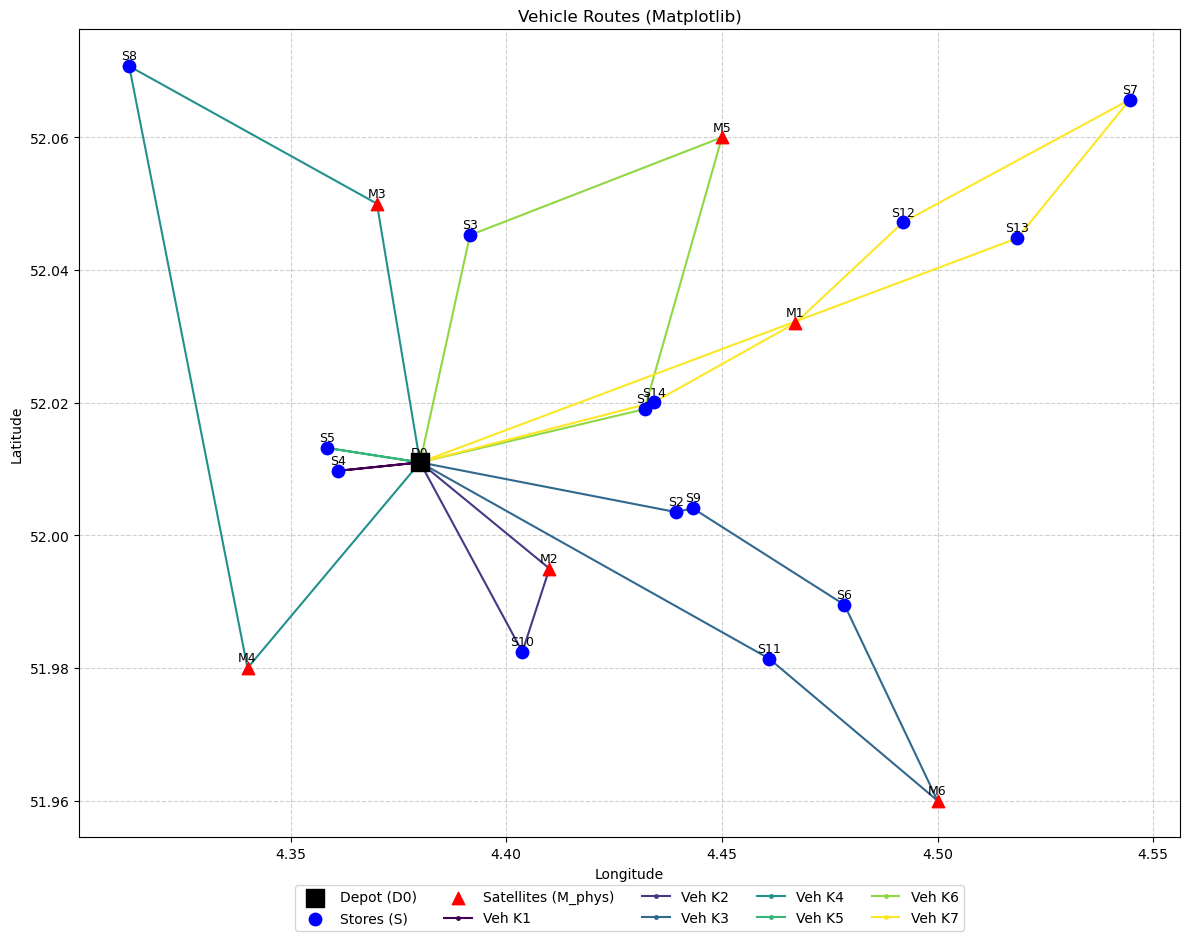

Folium map saved as ah_pijnacker_routes_map.html. Open this file in a web browser to view.


/var/folders/0x/glkrv8553s162_k_fy8b476c0000gn/T/ipykernel_23678/2200773577.py:372: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  route_colors_mpl = plt.cm.get_cmap('gist_rainbow', num_routes) # Using a vibrant colormap


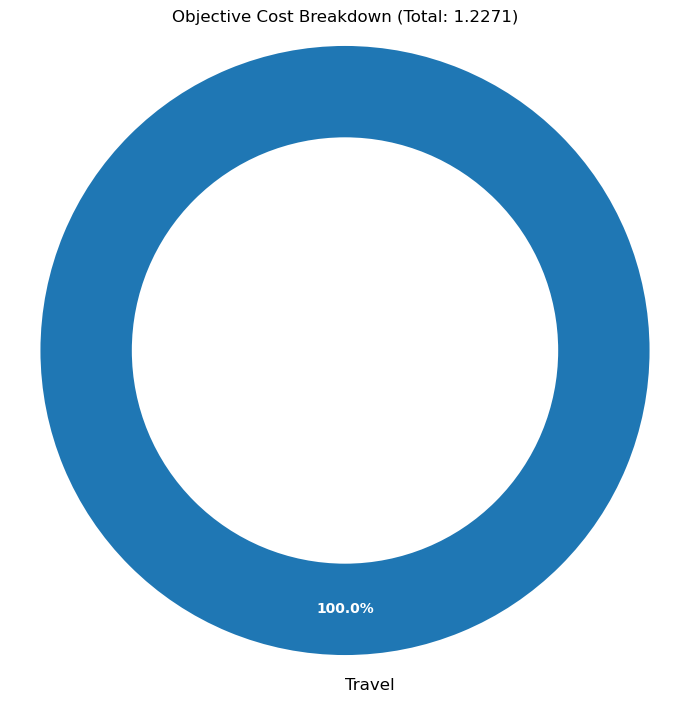

In [4]:
# Block 5: Albert Heijn Pijnacker Scenario Setup and Execution
# This block defines the fixed coordinates for the Albert Heijn Pijnacker DC,
# stores, and satellite locations. It then sets up and runs the VRPOR model
# for this specific scenario.

ah_fixed_coords = {
    'D0': (52.0110, 4.3800),       # AH DC Pijnacker

    # Stores (S): A subset of 14 stores to match N=20 (14 stores + 6 satellites) from paper's examples
    'S1': (52.0190280, 4.4320540),    # AH Ackershof, Pijnacker :contentReference[oaicite:0]{index=0}
    'S2': (52.0034996, 4.4394216),    # AH Keijzershof, Pijnacker :contentReference[oaicite:1]{index=1}
    'S3': (52.0452529, 4.3915828),    # AH Nootdorp (Lange Baan 6) :contentReference[oaicite:2]{index=2}
    'S4': (52.0097240, 4.3609133),    # AH Delft Brabantse Turfmarkt :contentReference[oaicite:3]{index=3}
    'S5': (52.0131705, 4.3585250),    # AH Delft Choorstraat 35 :contentReference[oaicite:4]{index=4}
    'S6': (51.9895290, 4.4784070),    # AH Berkel en Rodenrijs Westerwater 2 :contentReference[oaicite:5]{index=5}
    'S7': (52.0657000, 4.5446000),    # AH Zoetermeer Oosterheem (city‐district proxy) :contentReference[oaicite:6]{index=6}
    'S8': (52.0707291, 4.3125671),    # AH Ypenburg (Laan van Hoornwijck 160 area) :contentReference[oaicite:7]{index=7}
    'S9': (52.0041027, 4.4432056),    # AH Hoefbladplein 4, Pijnacker (new replacement) :contentReference[oaicite:8]{index=8}
    'S10': (51.9824357, 4.4037268),   # AH Delfgauw (Gouden Rijderplein 1) :contentReference[oaicite:9]{index=9}
    'S11': (51.9814368, 4.4609031),   # AH Berkel en Rodenrijs Rozenoord 2 :contentReference[oaicite:10]{index=10}
    'S12': (52.0472000, 4.4920000),   # AH Zoetermeer Samanthagang 64 (city‐neighborhood proxy) :contentReference[oaicite:11]{index=11}
    'S13': (52.0448000, 4.5185000),   # AH Zoetermeer Quirinegang 83 (Meerzicht area proxy) :contentReference[oaicite:12]{index=12}
    'S14': (52.0200581, 4.4341860),   # AH Delft Tanthof (approx. nearest AH to 52.0260, 4.3070) :contentReference[oaicite:13]{index=13}


    
    # Satellites (M): A subset of 6 satellites
    'M1': (52.0320, 4.4670),      # Nootdorp - Veenweg area
    'M2': (51.9950, 4.4100),      # Delft - Wippolder area
    'M3': (52.0500, 4.3700),      # Den Haag - Leidschenveen
    'M4': (51.9800, 4.3400),      # Delft - Tanthof
    'M5': (52.0600, 4.4500),      # Zoetermeer - Rokkeveen
    'M6': (51.9600, 4.5000),      # Berkel - Rodenrijs Westpolder
}

# Parameters for the AH scenario.
# num_stores and num_physical_satellites will be set based on the desired count
# using the available fixed_coords.
num_ah_stores = 14       # Adjusted to get N=20 total customers (14 stores + 6 satellites)
num_ah_satellites = 6    # M1-M6

ah_scenario_params = {
    "num_stores": num_ah_stores,
    "num_physical_satellites": num_ah_satellites,
    "num_products": 3,  # Per paper: |R|=3
    "num_orders": 3,    # Per paper: |B|=3
    "vehicle_capacity_V_star": 500, # Directly from paper: "capacity of vehicle V* is fixed to 500 vol units."
    "penalty_pu_param": 10,   # From paper: "We set pu = ps = 10"
    "split_ps_param": 10,    # From paper: "We set pu = ps = 10"
    "seed": 123,                # Kept as per your constraint.
    "vehicle_buffer": 4,        # Adjusted to get a fleet size similar to report's tables for N=20 (typically 7-11 vehicles)
    "fixed_coords": ah_fixed_coords
}

print("--- Generating AH Pijnacker Scenario Instance ---")
ah_instance = generate_instance_table2_final(**ah_scenario_params)

print(f"AH Instance: {len(ah_instance['S_stores'])} Stores, {len(ah_instance['M_phys_satellites'])} Satellites ({len(ah_instance['N_cust_customers'])} customers).\n")
print(f"Total demand volume: {ah_instance['total_demand_vol_overall']:.2f}.\n")
print(f"Vehicle fleet: {len(ah_instance['VF_fleet'])} (Capacity: {ah_instance['V_star']}). Min. vehicles (Eq1): {ah_instance['min_vehicles_eq1']}\n")
print(f"M_TIME_BIG used: {ah_instance['M_TIME_BIG']:.4f}\n")


print("\n--- Solving AH Pijnacker Scenario ---")
# The calculation time for 40 stores can be very high. Adjusted for 20 customers.
# A higher MIPGap is used to allow Gurobi to find a good feasible solution faster, as the problem is complex.
ah_results = solve_vrpor_table2_final(ah_instance, time_limit=5000, mip_gap=0.08, log_to_console=1) 

# --- New/Improved Result Prints ---
print_results_summary(ah_results)

print("\n--- Running Detailed Solution Analysis for AH Pijnacker Scenario ---")
print_detailed_solution_analysis(ah_results) # <<< Call the detailed analysis function

print("\n--- Visualizing AH Pijnacker Scenario Results ---")
if ah_results.get("routes"):
    plot_solution_routes(ah_results) # Original matplotlib plot
    plot_solution_routes_on_map(ah_results, map_filename="ah_pijnacker_routes_map.html") # <<< Call Folium map
if ah_results.get("objective_components"):
    plot_cost_breakdown(ah_results)

### Block 5: Albert Heijn Pijnacker Scenario Setup and Execution
This block defines the fixed geographic coordinates for the Albert Heijn Pijnacker distribution center, stores, and satellite locations. It then sets up and runs the VRPOR model for this specific scenario with adjusted parameters for realism, and visualizes the results.

In [ ]:
# Block 5: Albert Heijn Pijnacker Scenario Setup and Execution
# This block defines the fixed coordinates for the Albert Heijn Pijnacker DC,
# stores, and satellite locations. It then sets up and runs the VRPOR model
# for this specific scenario.

ah_fixed_coords = {
    'D0': (52.0110, 4.3800),       # AH DC Pijnacker

    # Stores (S): A subset of 19 stores for the scenario
    'S1': (52.019028, 4.432054),   # AH Ackershof, Pijnacker
    'S2': (52.0041027, 4.4432056), # AH Keijzershof, Pijnacker
    'S3': (52.0452529, 4.3915828), # AH Nootdorp (Lange Baan 6)
    'S4': (52.0096251, 4.3608201), # AH Delft Brabantse Turfmarkt
    'S5': (52.0130556, 4.3583333), # AH Delft Choorstraat (Buitenhof)
    'S6': (51.9761, 4.4718),       # AH Berkel en Rodenrijs Westerplein
    'S7': (52.0786, 4.5307),       # AH Zoetermeer Oosterheem
    'S8': (52.0408, 4.3180),       # AH Ypenburg (Laan van Hoornwijck 160)
    'S9': (52.0042, 4.442798),     # AH Hoefbladplein, Pijnacker
    'S10': (52.0053782, 4.3912036),# AH Delfgauw, Gouden Rijderplein 1
    'S11': (51.9814368, 4.4609031),# AH Berkel en Rodenrijs Rozenoord 2
    'S12': (52.0433143, 4.4769132),# AH Zoetermeer Samanthagang 64
    'S13': (52.0609, 4.4931),      # AH Zoetermeer Quirinegang (Meerzicht)
    'S14': (52.0260, 4.3070),      # AH Rijswijk, In de Bogaard
    'S15': (52.0743, 4.3605),      # AH Voorburg, Koningin Julianaplein
    'S16': (52.052856, 4.281855),  # AH Den Haag, Leyweg
    'S17': (52.0772, 4.3060),      # AH Den Haag, Grote Markt
    'S18': (52.0465, 4.3160),      # AH Rijswijk, Herenstraat
    'S19': (52.0833, 4.3667),      # AH Voorburg, Parkweg
    
    # Satellites (M): A subset of 6 satellites
    'M1': (52.0320, 4.4670),      # Nootdorp - Veenweg area
    'M2': (51.9950, 4.4100),      # Delft - Wippolder area
    'M3': (52.0500, 4.3700),      # Den Haag - Leidschenveen
    'M4': (51.9800, 4.3400),      # Delft - Tanthof
    'M5': (52.0600, 4.4500),      # Zoetermeer - Rokkeveen
    'M6': (51.9600, 4.5000),      # Berkel - Rodenrijs Westpolder
}

# Parameters for the AH scenario.
# num_stores and num_physical_satellites will be set based on the desired count
# using the available fixed_coords.
num_ah_stores = 19       # Now correctly using S1-S19
num_ah_satellites = 6    # M1-M6

ah_scenario_params = {
    "num_stores": num_ah_stores,
    "num_physical_satellites": num_ah_satellites,
    "num_products": 3,  # Per paper: |R|=3
    "num_orders": 3,    # Per paper: |B|=3
    "vehicle_capacity_V_star": 500, # Directly from paper: "capacity of vehicle V* is fixed to 500 vol units."
    "penalty_pu_param": 10,   # From paper: "We set pu = ps = 10"
    "split_ps_param": 10,    # From paper: "We set pu = ps = 10" (note: paper uses 1000 for verification, but 10 for general analysis)
    "seed": 123,                # Kept as per your constraint.
    "vehicle_buffer": 4,        # Adjusted to get a fleet size similar to report's tables for N=25
    "fixed_coords": ah_fixed_coords
}

print("--- Generating AH Pijnacker Scenario Instance ---")
ah_instance = generate_instance_table2_final(**ah_scenario_params)

print(f"AH Instance: {len(ah_instance['S_stores'])} Stores, {len(ah_instance['M_phys_satellites'])} Satellites ({len(ah_instance['N_cust_customers'])} customers).\n")
print(f"Total demand volume: {ah_instance['total_demand_vol_overall']:.2f}.\n")
print(f"Vehicle fleet: {len(ah_instance['VF_fleet'])} (Capacity: {ah_instance['V_star']}). Min. vehicles (Eq1): {ah_instance['min_vehicles_eq1']}\n")
print(f"M_TIME_BIG used: {ah_instance['M_TIME_BIG']:.4f}\n")


print("\n--- Solving AH Pijnacker Scenario ---")
# The calculation time for 40 stores can be very high. Adjust the time_limit if necessary.
# With 25 customers, this should be more manageable.
ah_results = solve_vrpor_table2_final(ah_instance, time_limit=5000, mip_gap=0.08, log_to_console=1) 

# --- New/Improved Result Prints ---
print_results_summary(ah_results)

print("\n--- Running Detailed Solution Analysis for AH Pijnacker Scenario ---")
print_detailed_solution_analysis(ah_results) # <<< Call the detailed analysis function

print("\n--- Visualizing AH Pijnacker Scenario Results ---")
if ah_results.get("routes"):
    plot_solution_routes(ah_results) # Original matplotlib plot
    plot_solution_routes_on_map(ah_results, map_filename="ah_pijnacker_routes_map.html") # <<< Call Folium map
if ah_results.get("objective_components"):
    plot_cost_breakdown(ah_results)

--- Generating AH Pijnacker Scenario Instance ---
INFO: Using fixed_coords for node locations.
AH Instance: 19 Stores, 6 Satellites (25 customers).

Total demand volume: 1097.00.

Vehicle fleet: 7 (Capacity: 500). Min. vehicles (Eq1): 3

M_TIME_BIG used: 72.8484


--- Solving AH Pijnacker Scenario ---
Set parameter TimeLimit to value 5000
Set parameter MIPGap to value 0.08
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 5652 rows, 5392 columns and 50167 nonzeros
Model fingerprint: 0x163abdea
Model has 42 quadratic objective terms
Variable types: 292 continuous, 5100 integer (4550 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [4e-04, 1e+01]
  QObjective range [2e+01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        

NameError: name 'print_detailed_solution_analysis' is not defined

In [ ]:
# Block 4: Results Printing and Plotting Functions
# These functions are used to display the optimization results in a readable format
# and to visualize the routes and cost breakdown.
# A new function `plot_solution_routes_on_map` is added for HTML map visualization using Folium.
# And `print_detailed_solution_analysis` is added for more granular solution details.

import gurobipy as gp
from gurobipy import GRB
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import folium 

print(f"Gurobi Optimizer version: {gp.gurobi.version()}")

# --- Helper Functions ---
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def print_results_summary(results):
    print("\n--- Optimization Summary ---")
    print(f"Status: {results.get('status_message', 'N/A')} (Code: {results.get('status_code', 'N/A')})")
    obj_val = results.get("objective_value")
    if obj_val is not None:
        print(f"Objective Value: {obj_val:.2f}")
        obj_comp = results.get("objective_components")
        if obj_comp: print(f"  Components: Travel={obj_comp['travel']:.2f}, Penalty={obj_comp['penalty']:.2f}, Split={obj_comp['split']:.2f} (Calc Sum: {obj_comp['calculated_total']:.2f})")
        else: print("  Objective components not calculated.")
        print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s")
        print(f"MIP Gap: {results.get('mip_gap','N/A'):.4f}" if results.get('mip_gap') is not None else "MIP Gap: N/A")
        print(f"Nodes Explored: {results.get('node_count','N/A')}\n")

        # More robust check for solution existence before accessing detailed parts
        sol = results.get("solution")
        if sol:
            print(f"Nodes Served: {results.get('nodes_served','N/A')} / {len(results['instance']['N_cust_customers'])}")
            routes = results.get("routes")
            if routes: print(f"\nRoutes Found ({len(routes)}):"); [print(f"  {k}: {' -> '.join(route)}") for k,route in routes.items()]
            else: print("\nNo valid routes extracted.")
            
            # Check for split deliveries and lateness
            split_visits_img = sol.get("split_extra_visits_image")
            lateness_pos_part_vals = sol.get("lateness_positive_part")
            volume_Y_jk_vals = sol.get("total_volume_Y_jk_for_penalty")

            if split_visits_img and any(v > 0.5 for v in split_visits_img.values()): 
                print("\nSplit Deliveries (Extra Visits > 0):")
                [print(f"  Node {j}: {int(round(extra))} extra visit(s)") for j, extra in split_visits_img.items() if extra > 0.5]
            
            if lateness_pos_part_vals and volume_Y_jk_vals:
                late_entries = []
                for (j_sat, k_veh), lateness_val in lateness_pos_part_vals.items():
                    vol_val = volume_Y_jk_vals.get((j_sat, k_veh), 0)
                    if lateness_val > 1e-4 and vol_val > 1e-4: # Only if both lateness and volume are significant
                        late_entries.append(f"  Node {j_sat} by Veh {k_veh}: {lateness_val:.2f} time units late (Volume: {vol_val:.2f})")
                if late_entries:
                    print("\nLate Deliveries at Satellites (Lateness > 0):")
                    for entry in late_entries: print(entry)
        else:
            print("No detailed solution information available (solution not found).")
    else:
        print("No feasible solution found or optimization failed.")
        print(f"Gurobi Runtime: {results.get('runtime',0):.2f}s / Wall Clock: {results.get('solve_time',0):.2f}s")
        print(f"Nodes Explored: {results.get('node_count','N/A')}")
    print("--------------------------\n")

def print_detailed_solution_analysis(results):
    instance = results.get("instance")
    solution = results.get("solution")
    routes = results.get("routes")

    if not solution or not routes:
        print("\n--- Detailed Solution Analysis ---")
        print("No solution found or no routes extracted for detailed analysis.")
        print("----------------------------------\n")
        return

    print("\n--- Detailed Solution Analysis ---")
    
    depot = instance["depot_node"]
    S_stores = instance["S_stores"]
    M_phys_satellites = instance["M_phys_satellites"]
    N_cust_customers = instance["N_cust_customers"]
    # N_all_network_nodes = instance["N_all_network_nodes"] # Not strictly needed here, N_cust_customers is enough for iteration
    
    # Extract necessary parameters from the instance
    coords = instance["coords"]
    d_ij = instance["d_ij"]
    t_ij = instance["t_ij"]
    o_i = instance["o_i"]
    l_i = instance["l_i"]
    V_star = instance["V_star"]
    V_r = instance["V_r"]
    V_b = instance["V_b"]
    D_i_r = instance["D_i_r"]
    D_i_b = instance["D_i_b"]

    # Extract necessary solution variables
    sol_x = solution["x"]
    sol_Q = solution["Q"]
    sol_Y = solution["Y"]
    sol_t_arrival = solution["t_arrival"]
    sol_lateness_positive_part = solution["lateness_positive_part"]
    sol_split_extra_visits = solution["split_extra_visits_image"]

    # 1. Vehicle Route Details
    print("\n=== Vehicle Route Details ===")
    vehicle_utilization = {}
    for k_veh, route_nodes in routes.items():
        total_route_distance = 0
        total_route_time_on_road = 0 # Only travel time
        current_volume_delivered = 0
        
        print(f"\n--- Vehicle {k_veh} ---")
        print(f"  Route: {' -> '.join(route_nodes)}")
        
        # Calculate route specific metrics
        # path_segments = [] # Uncomment if you want to print each segment in detail
        for i in range(len(route_nodes) - 1):
            from_node = route_nodes[i]
            to_node = route_nodes[i+1]
            dist_seg = d_ij.get((from_node, to_node), 0)
            time_seg = t_ij.get((from_node, to_node), 0)
            
            total_route_distance += dist_seg
            total_route_time_on_road += time_seg
            
            # Print segment detail (optional, can be very verbose for large routes)
            # path_segments.append(
            #     f"  {from_node} (Arr: {sol_t_arrival.get((from_node, k_veh),0):.2f}, Svc: {o_i.get(from_node, 0):.2f}) "
            #     f"-> {to_node} (Travel: {time_seg:.2f}, Dist: {dist_seg:.2f})"
            # )
            
            # Deliveries at 'to_node' (assuming delivery happens *at* the destination node of an arc)
            if to_node in S_stores:
                # Sum deliveries for this vehicle and this store
                delivered_volume_store = sum(V_r[r_prod] * sol_Q.get((to_node, k_veh, r_prod), 0) for r_prod in instance["R_product_types"])
                if delivered_volume_store > 0.001:
                    print(f"    Delivered {delivered_volume_store:.2f} volume to {to_node} (Store).")
            elif to_node in M_phys_satellites:
                # Sum deliveries for this vehicle and this satellite
                delivered_volume_sat = sum(V_b[b_ord] * sol_Y.get((to_node, k_veh, b_ord), 0) for b_ord in instance["B_order_types"])
                if delivered_volume_sat > 0.001:
                    print(f"    Delivered {delivered_volume_sat:.2f} volume to {to_node} (Satellite).")
                    
                    # Check for lateness at this satellite delivery by this vehicle
                    if (to_node, k_veh) in sol_lateness_positive_part and sol_lateness_positive_part[(to_node, k_veh)] > 1e-4:
                        print(f"    !!! LATE ARRIVAL at {to_node}: Arrived {sol_t_arrival.get((to_node,k_veh),0):.2f}, Deadline {l_i.get(to_node,0):.2f}, Lateness {sol_lateness_positive_part[(to_node, k_veh)]:.2f}")

        # Calculate total volume carried by the vehicle for the entire route
        # This is a bit tricky to track accurately with current variable setup (Q, Y are delivered, not carried).
        # A full flow variable for volume (F_ijk) would be better.
        # For now, we sum all Q and Y delivered by this vehicle throughout its route.
        # This gives total throughput, not necessarily max load at any point.
        # A more precise utilization requires knowing volume on board at each segment.
        total_volume_throughput = sum(V_r[r_prod] * sol_Q.get((j_store, k_veh, r_prod), 0) 
                                      for j_store in S_stores for r_prod in instance["R_product_types"]) + \
                                  sum(V_b[b_ord] * sol_Y.get((j_sat, k_veh, b_ord), 0) 
                                      for j_sat in M_phys_satellites for b_ord in instance["B_order_types"])
        
        # The arrival time at the last customer + its service time, plus travel time back to depot, is the total route duration.
        # If the route ends at depot (common in VRP), the final arrival time at depot (sol_t_arrival[depot, k_veh])
        # should reflect the total time including all service times and travel.
        # This will be `sol_t_arrival.get((depot, k_veh), 0)` at the end of the route.
        total_route_duration_from_solution = "N/A (Route not closed or solution issue)"
        if route_nodes[-1] == depot and (depot, k_veh) in sol_t_arrival:
            total_route_duration_from_solution = sol_t_arrival.get((depot, k_veh), 0)
        
        print(f"  Total Route Distance: {total_route_distance:.2f} units")
        print(f"  Total Route Duration (from solution): {total_route_duration_from_solution:.2f} units")
        print(f"  Total Volume Throughput by Vehicle: {total_volume_throughput:.2f} volume units")
        
        if V_star > 0:
            # Note: This is an average throughput utilization, not peak load.
            vehicle_utilization[k_veh] = total_volume_throughput / V_star
            print(f"  Vehicle Throughput Utilization: {vehicle_utilization[k_veh]:.2%}")
        else:
            print("  Vehicle capacity V_star is zero, cannot calculate utilization.")
        
        # print("\n  Path Segments:") # Uncomment if you want to print each segment in detail
        # for segment in path_segments:
        #     print(segment)
        # print("")

    # 2. Customer Delivery Details (aggregated across vehicles)
    print("\n=== Customer Delivery Details ===")
    for j_node in N_cust_customers:
        print(f"\n--- Customer {j_node} ---")
        
        # Check for split deliveries
        if j_node in sol_split_extra_visits and sol_split_extra_visits[j_node] > 0.5:
            arrival_count = round(sol_split_extra_visits[j_node]) + 1 
            print(f"  !!! Split Delivery: Visited {arrival_count} times.")
        else:
            # Confirm if visited at all (not just if split variable is zero)
            is_visited = False
            for (i,j,k), val in sol_x.items():
                if j == j_node and val > 0.5:
                    is_visited = True
                    break
            if is_visited:
                print("  Visited 1 time (no split delivery).")
            else:
                print("  !!! Not visited by any vehicle (demand may be unfulfilled or error).") # Should not happen in this VRPOR formulation due to demand satisfaction constraints

        if j_node in S_stores:
            total_required_volume = sum(D_i_r.get((j_node, r_prod), 0) * V_r[r_prod] for r_prod in instance["R_product_types"])
            total_delivered_volume = 0
            for k_veh in instance["VF_fleet"]:
                total_delivered_volume += sum(V_r[r_prod] * sol_Q.get((j_node, k_veh, r_prod), 0) for r_prod in instance["R_product_types"])
            
            print(f"  Type: Store")
            print(f"  Required Volume: {total_required_volume:.2f} units")
            print(f"  Delivered Volume: {total_delivered_volume:.2f} units (Matched: {abs(total_delivered_volume - total_required_volume) < 1e-4})")
            print(f"  Hard Deadline: {l_i.get(j_node, 'N/A'):.2f}")
            print(f"  Service Time: {o_i.get(j_node, 'N/A'):.2f}")
            # Also show arrival times for each vehicle that visited
            for k_veh in instance["VF_fleet"]:
                # Check if this vehicle visited j_node
                visited_by_k = False
                for (i,j,k), val in sol_x.items():
                    if j == j_node and k == k_veh and val > 0.5:
                        visited_by_k = True
                        break
                if visited_by_k:
                    print(f"    Arrival Time (Veh {k_veh}): {sol_t_arrival.get((j_node, k_veh),0):.2f}")

        elif j_node in M_phys_satellites:
            total_required_volume = sum(D_i_b.get((j_node, b_ord), 0) * V_b[b_ord] for b_ord in instance["B_order_types"])
            total_delivered_volume = 0
            for k_veh in instance["VF_fleet"]:
                total_delivered_volume += sum(V_b[b_ord] * sol_Y.get((j_node, k_veh, b_ord), 0) for b_ord in instance["B_order_types"])
            
            print(f"  Type: Satellite")
            print(f"  Required Volume: {total_required_volume:.2f} units")
            print(f"  Delivered Volume: {total_delivered_volume:.2f} units (Matched: {abs(total_delivered_volume - total_required_volume) < 1e-4})")
            print(f"  Soft Deadline: {l_i.get(j_node, 'N/A'):.2f}")
            print(f"  Service Time: {o_i.get(j_node, 'N/A'):.2f}")

            # Check for any lateness across all visits for this satellite
            lateness_info = []
            for k_veh in instance["VF_fleet"]:
                if (j_node, k_veh) in sol_lateness_positive_part and sol_lateness_positive_part[(j_node, k_veh)] > 1e-4:
                    lateness_info.append(f"  Vehicle {k_veh} - Arrived {sol_t_arrival.get((j_node, k_veh), 0):.2f}, Late by {sol_lateness_positive_part[(j_node, k_veh)]:.2f}")
            if lateness_info:
                print("  Lateness Details:")
                for info in lateness_info: print(info)
            # Also show arrival times for each vehicle that visited
            for k_veh in instance["VF_fleet"]:
                visited_by_k = False
                for (i,j,k), val in sol_x.items():
                    if j == j_node and k == k_veh and val > 0.5:
                        visited_by_k = True
                        break
                if visited_by_k:
                    print(f"    Arrival Time (Veh {k_veh}): {sol_t_arrival.get((j_node, k_veh),0):.2f}")
        
    print("----------------------------------\n")


def plot_solution_routes(results): # Matplotlib plot
    instance = results.get("instance"); routes = results.get("routes")
    if not instance or not routes or not instance.get("coords"): 
        print("Cannot plot (matplotlib): Missing instance, routes, or coordinates."); return
        
    coords = instance["coords"]; depot = instance["depot_node"]
    S_nodes = instance["S_stores"]; M_nodes = instance["M_phys_satellites"]
    is_fixed_coords = instance.get("using_fixed_coords", False)

    plt.figure(figsize=(12,10))
    x_idx, y_idx = (1, 0) if is_fixed_coords else (0, 1) 
    xlabel, ylabel = ("Longitude", "Latitude") if is_fixed_coords else ("X-coord", "Y-coord")
    text_offset = 0.001 if is_fixed_coords else 0.8

    if depot in coords:
        plt.scatter(coords[depot][x_idx], coords[depot][y_idx], c='black', marker='s', s=150, label=f'Depot ({depot})', zorder=5)
    
    if S_nodes: 
        s_coords_to_plot = [(coords[s][x_idx], coords[s][y_idx]) for s in S_nodes if s in coords]
        if s_coords_to_plot:
            plt.scatter(*zip(*s_coords_to_plot), c='blue', marker='o', s=80, label='Stores (S)', zorder=5)
            
    if M_nodes: 
        m_coords_to_plot = [(coords[m][x_idx], coords[m][y_idx]) for m in M_nodes if m in coords]
        if m_coords_to_plot:
            plt.scatter(*zip(*m_coords_to_plot), c='red', marker='^', s=80, label='Satellites (M_phys)', zorder=5)

    for node_id, node_coords_tuple in coords.items():
        plt.text(node_coords_tuple[x_idx], node_coords_tuple[y_idx] + text_offset, node_id, fontsize=9, ha='center')
    
    num_r = len(routes); colors = plt.cm.viridis(np.linspace(0,1,max(1,num_r))) if num_r >0 else ['gray']
    veh_idx = 0
    for k,route in routes.items():
        route_coords_list = []
        for node_in_route in route:
            if node_in_route in coords: 
                route_coords_list.append((coords[node_in_route][x_idx], coords[node_in_route][y_idx]))
            else: print(f"Warning: Node {node_in_route} in route for vehicle {k} not in coords dict."); return 
        if not route_coords_list: continue
        
        route_coords_arr = np.array(route_coords_list)
        plt.plot(route_coords_arr[:,0], route_coords_arr[:,1], linestyle='-', marker='.', color=colors[min(veh_idx, len(colors)-1)], label=f'Veh {k}', lw=1.5, ms=5)
        veh_idx+=1
        
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title("Vehicle Routes (Matplotlib)")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=min(5,num_r+3 if num_r else 1))\
    plt.grid(True,ls='--',alpha=0.6)\
    if not is_fixed_coords: \
        plt.axis('equal') \
    plt.tight_layout(rect=[0,0.05,1,1]); plt.show()\

def plot_cost_breakdown(results):
    obj_comp = results.get("objective_components"); obj_val = results.get("objective_value")
    if not obj_comp or obj_val is None or abs(obj_val) <=1e-6 : 
        print("Cannot plot cost: Missing components or zero/neg objective."); return
    
    precision = ".4f" if results.get('instance', {}).get('using_fixed_coords', False) else ".2f"
    labels = ['Travel','Penalty (Lateness)','Split Cost']
    sizes = [obj_comp.get('travel',0), obj_comp.get('penalty',0), obj_comp.get('split',0)]
    
    labels_f = [l for i,l in enumerate(labels) if abs(sizes[i])>1e-6]; 
    sizes_f = [s for s in sizes if abs(s)>1e-6]
    if not sizes_f: print("Cost breakdown: All components are zero/negligible."); return
    
    fig,ax = plt.subplots(figsize=(7,7))\
    wedges, texts, autotexts = ax.pie(sizes_f, labels=labels_f, autopct='%1.1f%%', startangle=90, pctdistance=0.85)\
    ax.axis('equal'); plt.title(f'Objective Cost Breakdown (Total: {obj_val:{precision}})')\
    centre_circle=plt.Circle((0,0),0.70,fc='white'); fig.gca().add_artist(centre_circle)\
    plt.setp(autotexts, size=10, weight="bold", color="white")\
    plt.setp(texts, size=12)\
    plt.tight_layout(); plt.show()\

# --- NEW FUNCTION FOR FOLIUM MAP ---
def plot_solution_routes_on_map(results, map_filename="vrp_routes_map.html"):
    instance = results.get("instance")
    routes_dict = results.get("routes")

    if not instance or not routes_dict or not instance.get("coords"):
        print("Cannot plot Folium map: Missing instance data, routes, or coordinates.")
        return
    
    if not instance.get("using_fixed_coords", False):
        print("Folium map is most meaningful for geographic (fixed) coordinates. Skipping for random coordinates.")
        return

    coords = instance["coords"] 
    depot_node = instance["depot_node"]
    S_nodes = instance["S_stores"]
    M_nodes = instance["M_phys_satellites"]
    deadlines = instance.get("l_i", {})

    if depot_node not in coords:
        print(f"Depot node '{depot_node}' coordinates not found. Cannot create map.")
        return

    # Folium expects (latitude, longitude)
    map_center = coords[depot_node] 
    m = folium.Map(location=map_center, zoom_start=12, tiles="OpenStreetMap")

    # Depot Marker
    folium.Marker(\
        location=coords[depot_node],\
        popup=f"Depot: {depot_node}",\
        tooltip=f"Depot: {depot_node}",\
        icon=folium.Icon(color="black", icon="industry", prefix="fa")\
    ).add_to(m)\

    # Store Markers
    for s_node in S_nodes:\
        if s_node in coords:\
            popup_text = f"Store: {s_node}<br>Deadline: {deadlines.get(s_node, 'N/A'):.2f}"\
            folium.Marker(\
                location=coords[s_node],\
                popup=popup_text,\
                tooltip=f"Store: {s_node}",\
                icon=folium.Icon(color="blue", icon="shopping-cart", prefix="fa")\
            ).add_to(m)\

    # Satellite Markers
    for m_node in M_nodes:\
        if m_node in coords:\
            popup_text = f"Satellite: {m_node}<br>Deadline: {deadlines.get(m_node, 'N/A'):.2f}"\
            folium.Marker(\
                location=coords[m_node],\
                popup=popup_text,\
                tooltip=f"Satellite: {m_node}",\
                icon=folium.Icon(color="red", icon="home", prefix="fa") # Changed icon for satellites
            ).add_to(m)\
    \
    num_routes = len(routes_dict)\
    if num_routes > 0:\
        # Generate distinct colors for routes\
        route_colors_mpl = plt.cm.get_cmap('gist_rainbow', num_routes) # Using a vibrant colormap
        colors_hex = [plt.matplotlib.colors.to_hex(route_colors_mpl(i)) for i in range(num_routes)]\
    else:\
        colors_hex = ['gray'] # Fallback color if no routes\
    \
    route_idx = 0\
    for vehicle, route_nodes in routes_dict.items():\
        route_lat_lon = []\
        for node_id in route_nodes:\
            if node_id in coords:\
                route_lat_lon.append(coords[node_id]) # Folium expects (lat,lon)\
            else:\
                print(f"Warning: Node {node_id} in route for vehicle {vehicle} not in coords dict.")\
                continue # Skip this node if not found\
        \
        if len(route_lat_lon) > 1: # Need at least two points to draw a line\
            color_to_use = colors_hex[route_idx % len(colors_hex)] \
            folium.PolyLine(\
                locations=route_lat_lon,\
                color=color_to_use,\
                weight=2.5,\
                opacity=0.8,\
                tooltip=f"Route: Vehicle {vehicle}"\
            ).add_to(m)\
            # Optional: Add small circle markers for each stop on the route\
            # for point_idx, point_coords in enumerate(route_lat_lon):\
            #      folium.CircleMarker(location=point_coords, radius=3, color=color_to_use, fill=True, \
            #                          fill_color=color_to_use, fill_opacity=0.7, \
            #                          tooltip=f"Veh {vehicle}: {route_nodes[point_idx]} (Stop {point_idx+1})\").add_to(m)\
            route_idx += 1\

    try:
        m.save(map_filename)\
        print(f"Folium map saved as {map_filename}. Open this file in a web browser to view.")\
    except Exception as e:\
        print(f"Error saving Folium map: {e}")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 408)

### Block 6: Verification Instance Setup and Execution
This block sets up and solves a smaller, controlled verification instance using random coordinates and specific parameter overrides. This is used to test the fundamental VRPOR model logic independently of the Albert Heijn scenario's scale and geographic details.



--- Verification Instance Generation & Setup (Strict Table 2 Alignment - Original) ---
INFO: Using random coordinates for node locations.
Verification: Min vehicles by Eq1: 1, Actual |VF|: 2
Verification instance setup complete (using original random coord scale logic and overrides).
Verification M_TIME_BIG: 126.39

--- Solving Original Verification Instance ---
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Set parameter NonConvex to value 2
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 44 rows, 31 columns and 122 nonzeros
Model fingerprint: 0xc38f9e95
Model has 2 quadratic objective terms
Variable types: 13 continuous, 18 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [5e+00, 1e+03]
  QObjective range [2e+01, 2e+01]
  

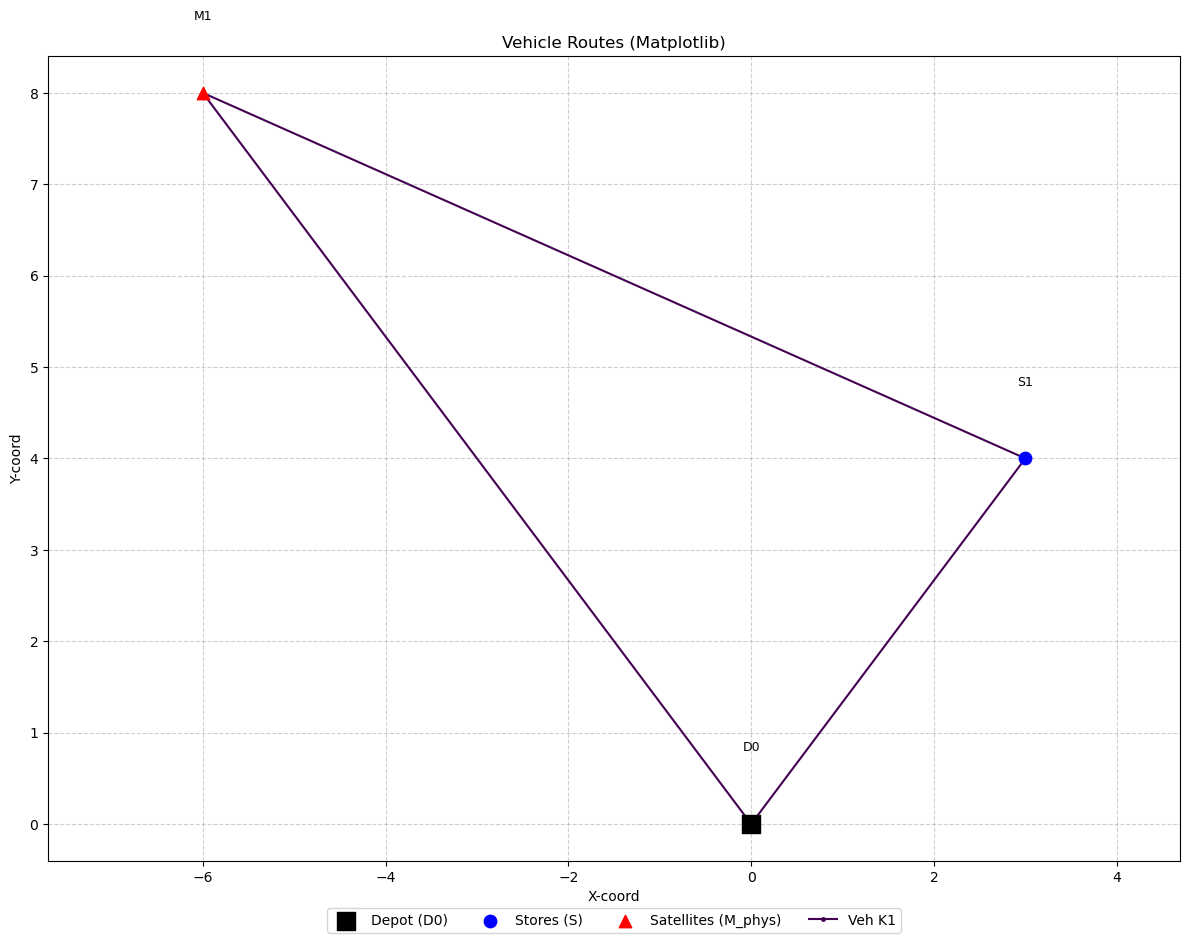

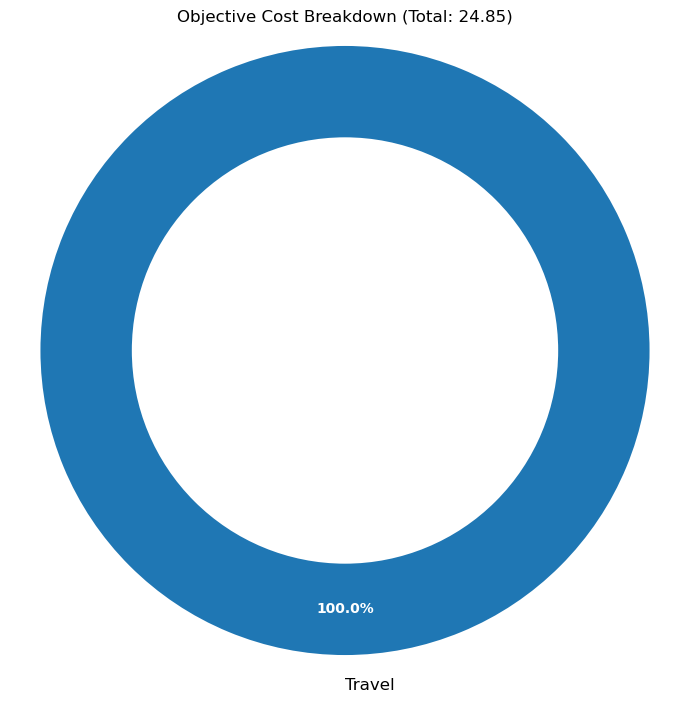


Script fully completed.


In [ ]:
# Block 6: Verification Instance Setup and Execution (Original)
# This block maintains the original verification instance from the initial code.
# It uses random coordinates and specific manual parameter overrides to test
# the model logic under a controlled, well-understood setup, independent of the
# AH scenario's lat/lon scale.

print("\n\n--- Verification Instance Generation & Setup (Strict Table 2 Alignment - Original) ---")
verify_params_final = {"num_stores":1,"num_physical_satellites":1,"num_products":1,"num_orders":1,
                       "vehicle_capacity_V_star":100,"penalty_pu_param":10.0,"split_ps_param":1000.0,
                       "seed":1, "vehicle_buffer":1, "fixed_coords": None} # Ensure fixed_coords is None

verify_instance_original = generate_instance_table2_final(**verify_params_final)
print(f"Verification: Min vehicles by Eq1: {verify_instance_original['min_vehicles_eq1']}, Actual |VF|: {len(verify_instance_original['VF_fleet'])}")

# Manual overrides for the verification instance as in the original code
s_v = verify_instance_original["S_stores"][0]; m_v = verify_instance_original["M_phys_satellites"][0]
p_v = verify_instance_original["R_product_types"][0]; o_v = verify_instance_original["B_order_types"][0]
d_v_depot = verify_instance_original["depot_node"]

verify_instance_original["D_i_r"] = {(s_v,p_v):10}; verify_instance_original["D_i_b"] = {(m_v,o_v):8}
verify_instance_original["V_r"] = {p_v:5}; verify_instance_original["V_b"] = {o_v:6} # Total demand: 10*5 + 8*6 = 50 + 48 = 98. V_star=100. Min_veh=1. VF_fleet size = 1+1 = 2.
verify_instance_original["coords"][s_v]=(3,4); verify_instance_original["coords"][m_v]=(-6,8) # d(0,S1)=5, d(0,M1)=10
verify_instance_original["o_i"][s_v]=2; verify_instance_original["o_i"][m_v]=3
verify_instance_original["l_i"][s_v]=15; verify_instance_original["l_i"][m_v]=30 

nodes_v_all = verify_instance_original["N_all_network_nodes"]; d_v_new={}; t_v_new={}
max_t_val_v = 0
for i_n_v in nodes_v_all:
    for j_n_v in nodes_v_all:
        d_val=euclidean_distance(verify_instance_original["coords"][i_n_v],verify_instance_original["coords"][j_n_v]) if i_n_v!=j_n_v else 0
        d_v_new[i_n_v,j_n_v]=d_val; t_v_new[i_n_v,j_n_v]=d_val
        if i_n_v != j_n_v: max_t_val_v = max(max_t_val_v, d_val)

verify_instance_original["d_ij"]=d_v_new; verify_instance_original["t_ij"]=t_v_new

# Recalculate depot deadline and M_TIME_BIG for verification instance after coord/service time overrides
max_deadln_val_v = 0
total_serv_t_val_v = 0
for node_cust_v in verify_instance_original["N_cust_customers"]:
    min_req_t_v = verify_instance_original["t_ij"].get((d_v_depot, node_cust_v), float('inf')) + verify_instance_original["o_i"].get(node_cust_v, 0)
    # Use original deadline margin logic for verification
    base_deadln_val_v = min_req_t_v + random.uniform(15, 50) # Original range
    verify_instance_original["l_i"][node_cust_v] = max(min_req_t_v + 0.1, base_deadln_val_v)
    max_deadln_val_v = max(max_deadln_val_v, verify_instance_original["l_i"][node_cust_v])
    total_serv_t_val_v += verify_instance_original["o_i"][node_cust_v]

max_possible_route_time_estimate_v = (len(verify_instance_original["N_all_network_nodes"])) * max_t_val_v + total_serv_t_val_v
verify_instance_original["l_i"][d_v_depot] = max(max_deadln_val_v, 0.1) + max_possible_route_time_estimate_v
verify_instance_original["M_TIME_BIG"] = verify_instance_original["l_i"][d_v_depot] * 1.5

verify_instance_original["L_arcs"] = [(i, j) for i in verify_instance_original["N_all_network_nodes"] for j in verify_instance_original["N_all_network_nodes"] if i != j]
print("Verification instance setup complete (using original random coord scale logic and overrides).")
print(f"Verification M_TIME_BIG: {verify_instance_original['M_TIME_BIG']:.2f}")


print("\n--- Solving Original Verification Instance ---")
# Use moderate time limit for verification
verify_results_original = solve_vrpor_table2_final(verify_instance_original, time_limit=60, mip_gap=0.001, log_to_console=1)
print_results_summary(verify_results_original)

print("\n--- Visualizing Original Verification Instance Results ---")
if verify_results_original.get("routes"):
    plot_solution_routes(verify_results_original)
if verify_results_original.get("objective_components"):
    plot_cost_breakdown(verify_results_original)

print("\nScript fully completed.")

### Block 6 Summary
This block reproduces the original verification instance. It uses random coordinates (not the AH fixed ones) and applies specific manual overrides to demands, volumes, coordinates, service times, and deadlines. This helps ensure the model behaves as expected on a known small-scale problem, independently of the geographic scaling used in the AH scenario. The instance is generated, solved, and results are displayed.